In [1]:
root = "../../.."

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from joblib import load

# Load data

In [3]:
kegg_decode = pd.read_csv("%s/output/pathway/SCFA/sankey/kegg_decode_sankey.csv"%(root), index_col=0)
blood_decode = pd.read_csv("%s/output/pathway/SCFA/sankey/responder_decode_sankey.csv"%(root), index_col=0)
kegg_list = kegg_decode.index.to_list()
blood_list = blood_decode.index.to_list()

In [4]:
def shap_load(omics_name, omics_list):
    omics_summary = dict()
    shap_table = pd.DataFrame(0, index=range(12), columns=omics_list)
    for i in range(12):
        shap_values = load("%s/codes/AI/output/shap/%s_score_%s.pkl"%(root, omics_name,i))
        if len(shap_values.values)==4 or len(shap_values.values)==5: 
            shap_data = pd.DataFrame(shap_values.values[0], 
                                     columns = shap_values.feature_names)/len(shap_values.values)
        else:
            shap_data = pd.DataFrame(shap_values.values, columns = shap_values.feature_names)
        
        # normalize to overcome the vary feature total number by dividing of abosolute sum
        shap_data_sum = shap_data.abs().sum(axis=0)
        shap_data = shap_data / shap_data_sum
        
        omics_list = [i for i in omics_list if i in shap_data.columns]
        shap_values = shap_data.loc[:,omics_list].mean(axis=0)
        shap_table.loc[i, omics_list] = shap_values
        
    score_name = pd.read_csv("%s/codes/AI/input/score.csv"%(root), index_col=0)
    score_name = score_name.columns.to_list()
    shap_table = shap_table.loc[:,omics_list]
    shap_table.index = score_name
    return shap_table.transpose()

In [5]:
kegg_shap = shap_load("kegg",kegg_list)
immune_shap = shap_load("immune",blood_list)
bioc_shap = shap_load("metabolome",blood_list)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Sum by catagories and write plot table

In [6]:
kegg_shap.loc[:,'Annotation'] = kegg_decode.Annotation
kegg_shap = kegg_shap.groupby('Annotation').sum()
immune_shap.loc[:,'Annotation'] = blood_decode.loc[immune_shap.index,'Annotation']
immune_shap = immune_shap.groupby('Annotation').sum()
bioc_shap.loc[:,'Annotation'] = blood_decode.loc[bioc_shap.index,'Annotation']
bioc_shap = bioc_shap.groupby('Annotation').sum()

In [7]:
def score_name_modify_for_plot(x):
    x = x.split('.')[1].replace("Role Limitations due to ", "")
    x = x.replace("Energy/", "")
    x = x.replace("sleeping_problem", "Sleeping\nProblem")
    x = x.replace("gastrointestinal", "Gastrointestinal")
    x = x.replace(" ", "\n")
    return x

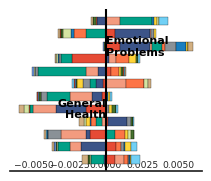

In [8]:
# Set the style
sns.set(style='ticks', font_scale=0.6, font='DejaVu Sans')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(2,1.7), constrained_layout=True)

# Combine data
combined_df = pd.concat([kegg_shap, immune_shap, bioc_shap], keys=['Kegg', 'Metabolome', 'Immune'])

# Create color dictionaries
color_dict = {row['Annotation']: row['Color'] for index, row in pd.concat([blood_decode,kegg_decode]).iterrows()}

# Prepare for plotting
score_label_list = kegg_shap.columns.to_list()
num_scores = len(score_label_list)
bar_height = 0.7
pos_start_list = [0] * num_scores
neg_start_list = [0] * num_scores

# Plotting loop
for i, score_label in enumerate(reversed(score_label_list)):
    for df_key in ['Kegg', 'Immune','Metabolome']:

        score_values = combined_df.xs(df_key)[score_label]
        pos_values = np.maximum(score_values, 0)
        neg_values = np.minimum(score_values, 0)

        for value_i in pos_values:
            if value_i != 0:  
                index_value_i = score_values.index[score_values == value_i][0]
                color_now = color_dict[index_value_i]
                ax.barh(i, value_i, left=pos_start_list[i], height=bar_height, color=color_now, edgecolor='black', linewidth=0.2)
                pos_start_list[i] += value_i

        for value_i in neg_values:
            if value_i != 0:
                index_value_i = score_values.index[score_values == value_i][0]
                color_now = color_dict[index_value_i]  
                ax.barh(i, value_i, left=neg_start_list[i], height=bar_height, color=color_now, edgecolor='black', linewidth=0.2)
                neg_start_list[i] += value_i


# Axis and label formatting
ax.axvline(x=0, color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=True)

# Set x-axis limits
max_range = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]))
ax.set_xlim([-max_range, max_range])
ax.tick_params(axis='x', direction='in', pad=-8)

# Add labels for the highest positive and lowest negative values
max_pos_y_position = np.argmax(pos_start_list)
min_neg_y_position = np.argmin(neg_start_list)

ax.text(0, max_pos_y_position, score_name_modify_for_plot(score_label_list[11-max_pos_y_position]), 
        ha='left', va='center', c = "black", fontsize=8, fontweight='bold')
ax.text(0, min_neg_y_position, score_name_modify_for_plot(score_label_list[11-min_neg_y_position]),
        ha='right', va='center', c = "black", fontsize=8, fontweight='bold')

# Save the figure
plt.savefig("%s/output/pathway/SCFA/Score_SHAP.png" %(root), dpi=1000, bbox_inches='tight', transparent=True)